In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder

In [2]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
original_df = pd.read_csv("/content/Exam_Score_Prediction.csv")
original_df2 = pd.read_csv("/content/student_performance_dataset.csv")
submission_df = pd.read_csv("/content/sample_submission.csv")

In [4]:
print(f"Train shape:    {train_df.shape}")
print(f"Test shape:     {test_df.shape}")
print(f"Original shape: {original_df.shape}")

Train shape:    (630000, 13)
Test shape:     (270000, 12)
Original shape: (20000, 13)


In [5]:
TARGET = "exam_score"
ID_COL = "id"

base_features = [col for col in train_df.columns if col not in [TARGET, ID_COL]]
CATS = train_df.select_dtypes("object").columns.to_list()

print(f"\nBase features: {len(base_features)}")
print(f"Categorical features: {CATS}")


Base features: 11
Categorical features: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [6]:
(train_df.describe(include='all'))

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
count,630000.000000,630000.000000,630000,630000,630000.000000,630000.000000,630000,630000.000000,630000,630000,630000,630000,630000.000000
unique,NaN,NaN,3,7,NaN,NaN,2,NaN,3,5,3,3,NaN
top,NaN,NaN,other,b.tech,NaN,NaN,yes,NaN,poor,coaching,medium,moderate,NaN
freq,NaN,NaN,211097,131236,NaN,NaN,579423,NaN,213675,131697,214082,353982,NaN
mean,314999.500000,20.545821,NaN,NaN,4.002337,71.987261,NaN,7.072758,NaN,NaN,NaN,NaN,62.506672
std,181865.479132,2.260238,NaN,NaN,2.359880,17.430098,NaN,1.744811,NaN,NaN,NaN,NaN,18.916884
min,0.000000,17.000000,NaN,NaN,0.080000,40.600000,NaN,4.100000,NaN,NaN,NaN,NaN,19.599000
25%,157499.750000,19.000000,NaN,NaN,1.970000,57.000000,NaN,5.600000,NaN,NaN,NaN,NaN,48.800000
50%,314999.500000,21.000000,NaN,NaN,4.000000,72.600000,NaN,7.100000,NaN,NaN,NaN,NaN,62.600000
75%,472499.250000,23.000000,NaN,NaN,6.050000,87.200000,NaN,8.600000,NaN,NaN,NaN,NaN,76.300000


In [7]:
print("Missing values:")
train_df.isnull().sum()

Missing values:


,0
id,0
age,0
gender,0
course,0
study_hours,0
class_attendance,0
internet_access,0
sleep_hours,0
sleep_quality,0
study_method,0


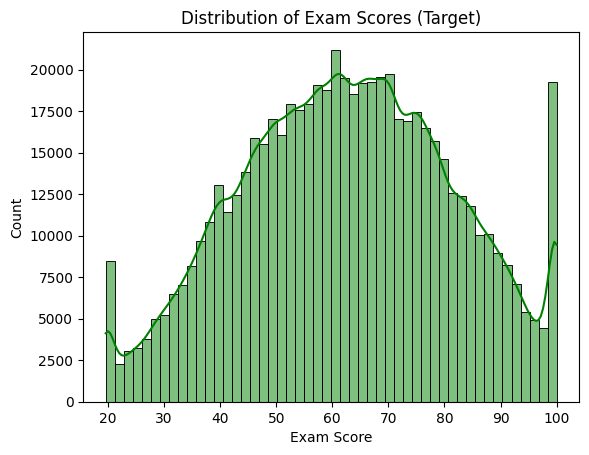

In [8]:
plt.figure()
sns.histplot(train_df[TARGET], bins=50, kde=True, color='green')
plt.title('Distribution of Exam Scores (Target)')
plt.xlabel('Exam Score')
plt.ylabel('Count')
plt.show()

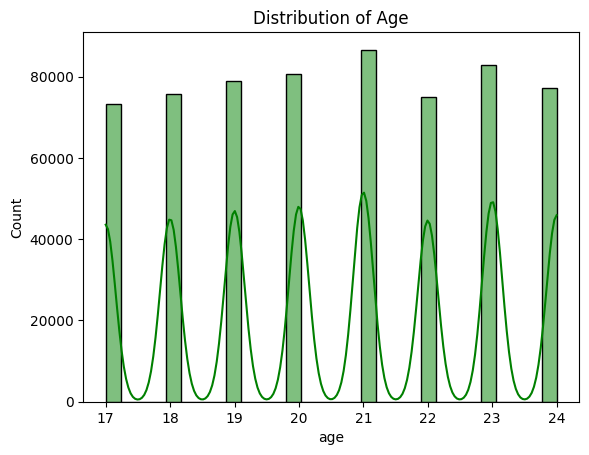

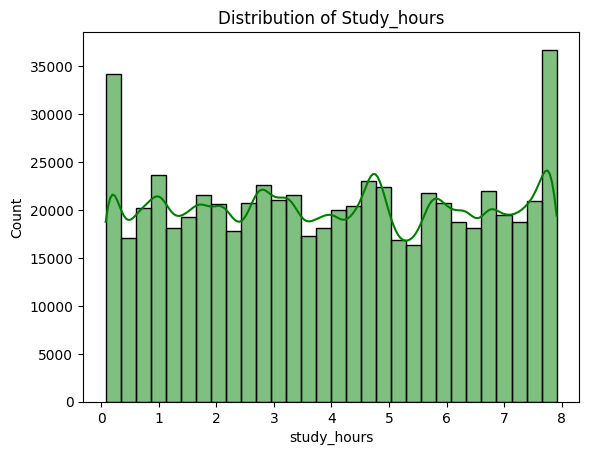

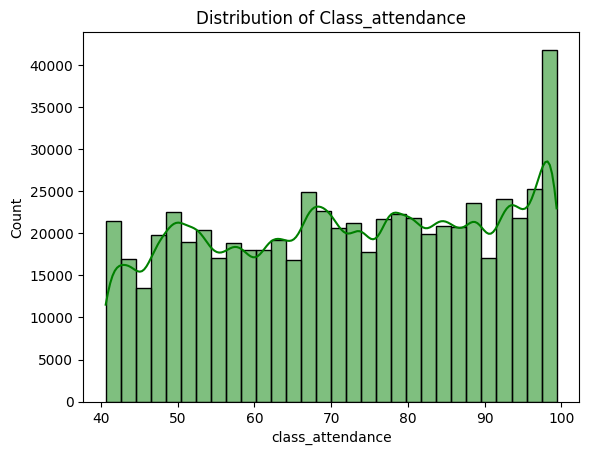

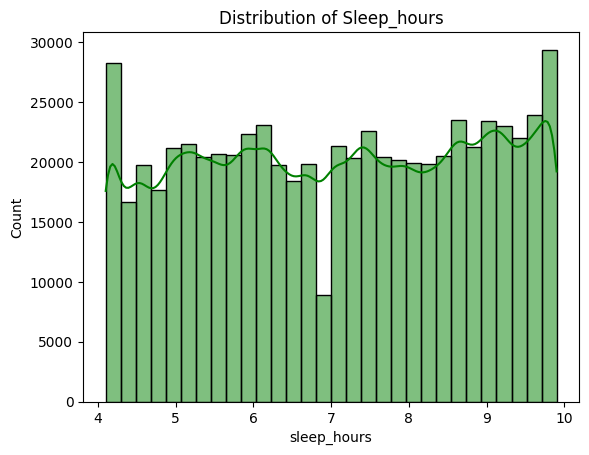

In [9]:
num_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
for col in num_cols:
    plt.figure()
    sns.histplot(train_df[col], bins=30, kde=True, color='green')
    plt.title(f'Distribution of {col.capitalize()}')
    plt.show()

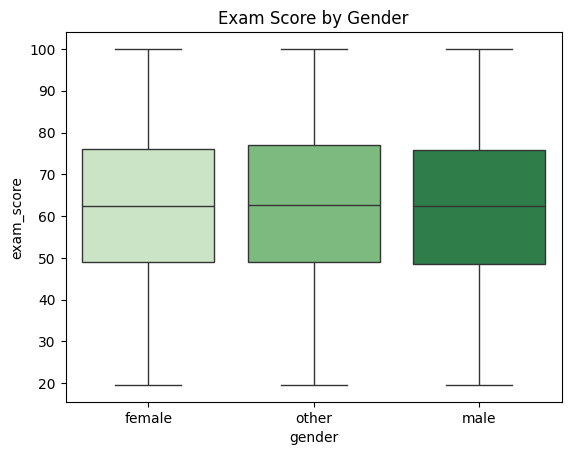

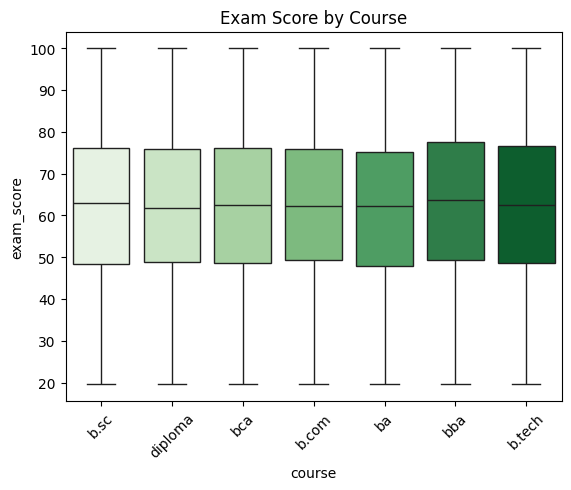

In [10]:
# Boxplots vs Target
plt.figure()
sns.boxplot(x='gender', y=TARGET, data=train_df,palette="Greens")
plt.title('Exam Score by Gender')
plt.show()

plt.figure()
sns.boxplot(x='course', y=TARGET, data=train_df,palette="Greens")
plt.xticks(rotation=45)
plt.title('Exam Score by Course')
plt.show()

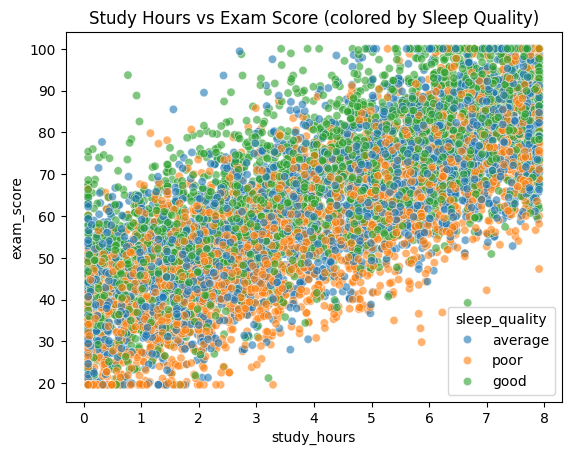

In [11]:
# Scatter (sample for speed)
sample = train_df.sample(10000, random_state=42)
plt.figure()
sns.scatterplot(x='study_hours', y=TARGET, hue='sleep_quality', data=sample, alpha=0.6)
plt.title('Study Hours vs Exam Score (colored by Sleep Quality)')
plt.show()

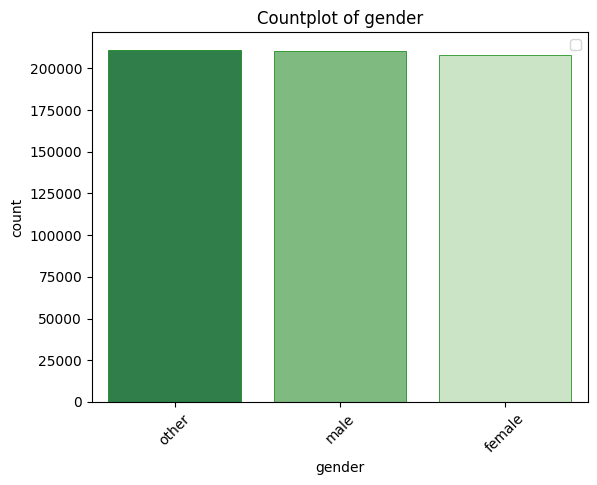

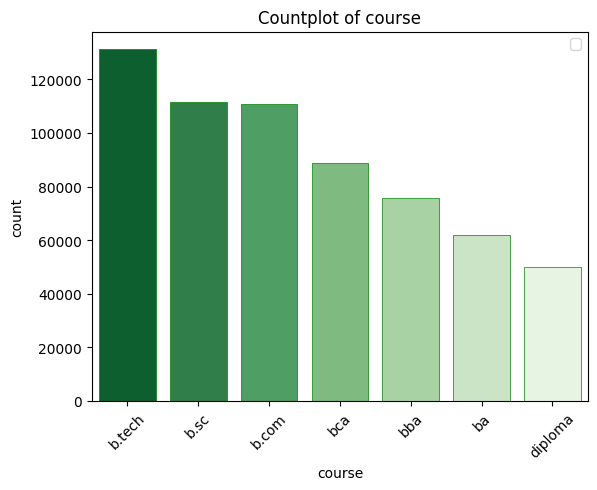

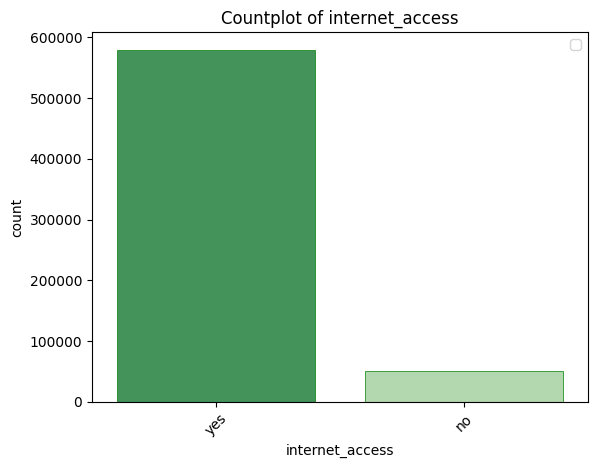

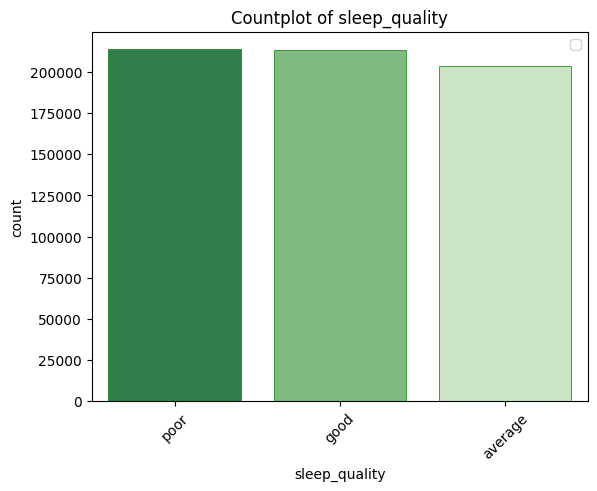

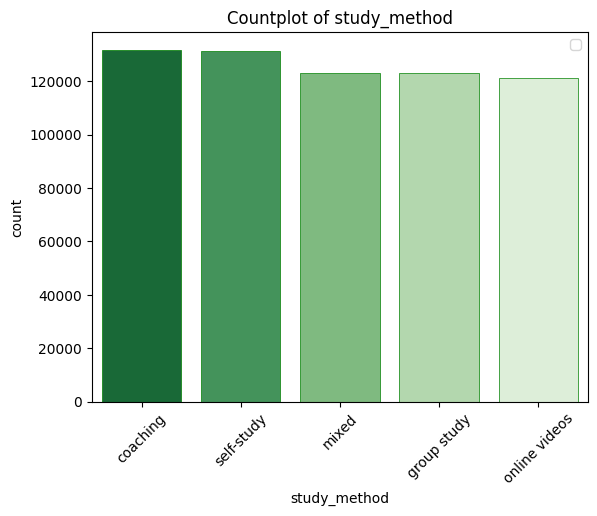

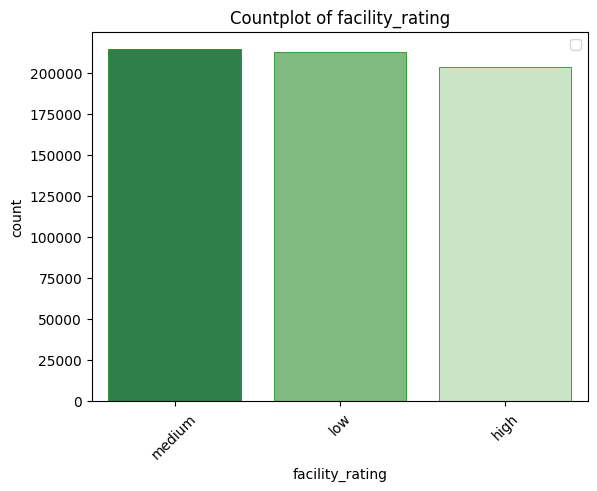

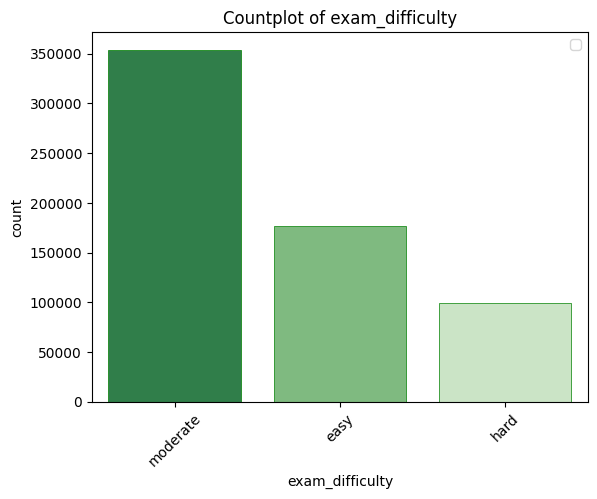

In [12]:
for col in CATS:

    plt.figure()
    row_order = train_df[col].value_counts().index

    sns.countplot(x=col, data=train_df, order=row_order, palette='Greens_r', legend=False, edgecolor='green', linewidth=.5)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

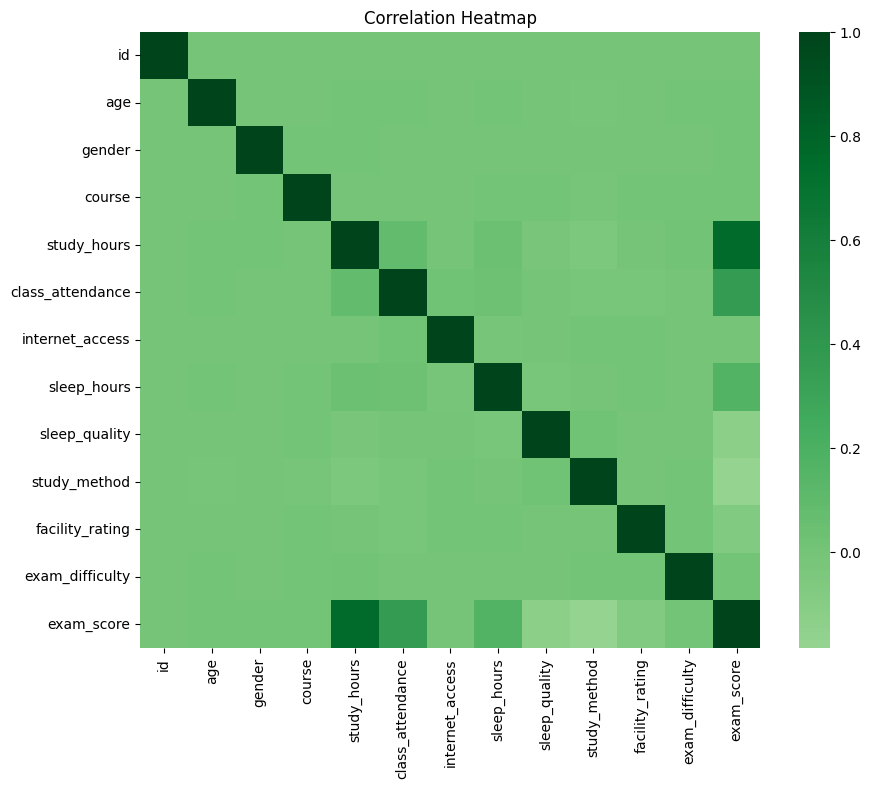

In [13]:
# Correlation (encode categoricals temporarily)
temp_df = train_df.copy()
for cat in CATS:
    temp_df[cat] = temp_df[cat].astype('category').cat.codes
corr = temp_df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='Greens', center=0, annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [14]:
def preprocess_optimized(df):
    """
    Generate high-value features INCLUDING binned features.
    Returns: (DataFrame with selected features, list of numeric feature names)
    """
    df_temp = df.copy()
    eps = 1e-5

    # Polynomials (2nd order only)
    df_temp['study_hours_squared'] = df_temp['study_hours'] ** 2
    df_temp['class_attendance_squared'] = df_temp['class_attendance'] ** 2
    df_temp['sleep_hours_squared'] = df_temp['sleep_hours'] ** 2
    df_temp['age_squared'] = df_temp['age'] ** 2

    # Log transforms
    sh_pos = df_temp['study_hours'].clip(lower=0)
    ca_pos = df_temp['class_attendance'].clip(lower=0)
    sl_pos = df_temp['sleep_hours'].clip(lower=0)

    df_temp['log_study_hours'] = np.log1p(sh_pos)
    df_temp['log_class_attendance'] = np.log1p(ca_pos)
    df_temp['log_sleep_hours'] = np.log1p(sl_pos)

    # Sqrt transforms
    df_temp['sqrt_study_hours'] = np.sqrt(sh_pos)
    df_temp['sqrt_class_attendance'] = np.sqrt(ca_pos)

    # Key interactions
    df_temp['study_hours_times_attendance'] = df_temp['study_hours'] * df_temp['class_attendance']
    df_temp['study_hours_times_sleep'] = df_temp['study_hours'] * df_temp['sleep_hours']
    df_temp['attendance_times_sleep'] = df_temp['class_attendance'] * df_temp['sleep_hours']
    df_temp['age_times_study_hours'] = df_temp['age'] * df_temp['study_hours']

    # Important ratios
    df_temp['study_hours_over_sleep'] = df_temp['study_hours'] / (df_temp['sleep_hours'] + eps)
    df_temp['attendance_over_sleep'] = df_temp['class_attendance'] / (df_temp['sleep_hours'] + eps)
    df_temp['attendance_over_study'] = df_temp['class_attendance'] / (df_temp['study_hours'] + eps)

    # Ordinal encoding
    sleep_quality_map = {'poor': 0, 'average': 1, 'good': 2}
    facility_rating_map = {'low': 0, 'medium': 1, 'high': 2}
    exam_difficulty_map = {'easy': 0, 'moderate': 1, 'hard': 2}

    df_temp['sleep_quality_numeric'] = df_temp['sleep_quality'].map(sleep_quality_map).fillna(1).astype(int)
    df_temp['facility_rating_numeric'] = df_temp['facility_rating'].map(facility_rating_map).fillna(1).astype(int)
    df_temp['exam_difficulty_numeric'] = df_temp['exam_difficulty'].map(exam_difficulty_map).fillna(1).astype(int)

    # Ordinal × numeric interactions
    df_temp['study_hours_times_sleep_quality'] = df_temp['study_hours'] * df_temp['sleep_quality_numeric']
    df_temp['attendance_times_facility'] = df_temp['class_attendance'] * df_temp['facility_rating_numeric']
    df_temp['sleep_hours_times_difficulty'] = df_temp['sleep_hours'] * df_temp['exam_difficulty_numeric']

    # Ordinal × ordinal interactions
    df_temp['facility_x_sleepq'] = df_temp['facility_rating_numeric'] * df_temp['sleep_quality_numeric']
    df_temp['difficulty_x_facility'] = df_temp['exam_difficulty_numeric'] * df_temp['facility_rating_numeric']

    # Rule-based flags
    df_temp["high_att_high_study"] = ((df_temp["class_attendance"] >= 90) & (df_temp["study_hours"] >= 6)).astype(int)
    df_temp["ideal_sleep_flag"] = ((df_temp["sleep_hours"] >= 7) & (df_temp["sleep_hours"] <= 9)).astype(int)
    df_temp["high_study_flag"] = (df_temp["study_hours"] >= 7).astype(int)

    # Composite efficiency
    df_temp['efficiency'] = (df_temp['study_hours'] * df_temp['class_attendance']) / (df_temp['sleep_hours'] + 1)

    # Gap features
    df_temp['sleep_gap_8'] = (df_temp['sleep_hours'] - 8.0).abs()
    df_temp['attendance_gap_100'] = (df_temp['class_attendance'] - 100.0).abs()

    # BINNED FEATURES (KEEP THESE - THEY ARE VALUABLE!)
    df_temp['study_bin_num'] = pd.cut(df_temp['study_hours'], bins=5, labels=False).astype(int)
    df_temp['attendance_bin_num'] = pd.cut(df_temp['class_attendance'], bins=5, labels=False).astype(int)
    df_temp['sleep_bin_num'] = pd.cut(df_temp['sleep_hours'], bins=5, labels=False).astype(int)
    df_temp['age_bin_num'] = pd.cut(df_temp['age'], bins=5, labels=False).astype(int)

    # Feature list (34 features total)
    numeric_features = [
        'study_hours_squared', 'class_attendance_squared', 'sleep_hours_squared', 'age_squared',
        'log_study_hours', 'log_class_attendance', 'log_sleep_hours',
        'sqrt_study_hours', 'sqrt_class_attendance',
        'study_hours_times_attendance', 'study_hours_times_sleep', 'attendance_times_sleep',
        'age_times_study_hours',
        'study_hours_over_sleep', 'attendance_over_sleep', 'attendance_over_study',
        'sleep_quality_numeric', 'facility_rating_numeric', 'exam_difficulty_numeric',
        'study_hours_times_sleep_quality', 'attendance_times_facility', 'sleep_hours_times_difficulty',
        'facility_x_sleepq', 'difficulty_x_facility',
        'high_att_high_study', 'ideal_sleep_flag', 'high_study_flag',
        'efficiency',
        'sleep_gap_8', 'attendance_gap_100',
        'study_bin_num', 'attendance_bin_num', 'sleep_bin_num', 'age_bin_num'
    ]

    return df_temp[base_features + numeric_features], numeric_features

In [15]:
X_raw, numeric_cols = preprocess_optimized(train_df)
y = train_df[TARGET].reset_index(drop=True)

X_test_raw, _ = preprocess_optimized(test_df)
X_orig_raw, _ = preprocess_optimized(original_df)
y_orig = original_df[TARGET].reset_index(drop=True)

full_data = pd.concat([X_raw, X_test_raw, X_orig_raw], axis=0, ignore_index=True)

for col in numeric_cols:
    full_data[col] = full_data[col].astype(float)

X = full_data.iloc[:len(train_df)].copy()
X_test = full_data.iloc[len(train_df):len(train_df) + len(test_df)].copy()
X_original = full_data.iloc[len(train_df) + len(test_df):].copy()

print(f"Engineered features: {len(numeric_cols)}")
print(f"Total features: {X.shape[1]} (11 base + {len(numeric_cols)} engineered)")

Engineered features: 34
Total features: 45 (11 base + 34 engineered)


In [16]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=1003)

oof_pred_lr = np.zeros(X.shape[0])
test_preds_lr = np.zeros((X_test.shape[0], FOLDS))
orig_preds_lr = np.zeros(X_original.shape[0])

for fold, (train_index, val_index) in enumerate(kf.split(X, y), start=1):
    X_train_fold, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_combined = pd.concat([X_train_fold, X_original], axis=0)
    y_train_combined = pd.concat([y_train_fold, y_orig], axis=0)

    target_encoder = TargetEncoder(smooth='auto', target_type='continuous')
    X_train_encoded = X_train_combined.copy()
    X_val_encoded = X_val.copy()
    X_test_encoded = X_test.copy()

    X_train_encoded[CATS] = target_encoder.fit_transform(X_train_combined[CATS], y_train_combined)
    X_val_encoded[CATS] = target_encoder.transform(X_val[CATS])
    X_test_encoded[CATS] = target_encoder.transform(X_test[CATS])

    alphas = np.logspace(-3, 3, 20)
    lr_model = RidgeCV(alphas=alphas, cv=5, scoring='neg_root_mean_squared_error')
    lr_model.fit(X_train_encoded, y_train_combined.to_numpy().ravel())

    lr_val_pred = np.clip(lr_model.predict(X_val_encoded), 0, 100)
    lr_test_pred = np.clip(lr_model.predict(X_test_encoded), 0, 100)
    lr_orig_pred = np.clip(lr_model.predict(X_train_encoded.iloc[-X_original.shape[0]:]), 0, 100)

    oof_pred_lr[val_index] = lr_val_pred
    test_preds_lr[:, fold - 1] = lr_test_pred
    orig_preds_lr += lr_orig_pred / FOLDS

    rmse_lr = np.sqrt(mean_squared_error(y_val, lr_val_pred))
    print(f"Fold {fold:2d} | RMSE: {rmse_lr:.6f}")

lr_oof_rmse = np.sqrt(mean_squared_error(y, oof_pred_lr))
print(f"\nRidge OOF RMSE: {lr_oof_rmse:.6f}")

Fold  1 | RMSE: 8.869874
Fold  2 | RMSE: 8.962132
Fold  3 | RMSE: 8.866707
Fold  4 | RMSE: 8.876907
Fold  5 | RMSE: 8.889321
Fold  6 | RMSE: 8.902958
Fold  7 | RMSE: 8.889453
Fold  8 | RMSE: 8.867452
Fold  9 | RMSE: 8.917315
Fold 10 | RMSE: 8.889268

Ridge OOF RMSE: 8.893182


In [17]:
# For XGBoost (categorical features as category type)
for col in base_features:
    full_data[col] = full_data[col].astype(str).astype("category")

for col in numeric_cols:
    full_data[col] = full_data[col].astype(float)

X_xgb = full_data.iloc[:len(train_df)].copy()
X_test_xgb = full_data.iloc[len(train_df):len(train_df) + len(test_df)].copy()
X_original_xgb = full_data.iloc[len(train_df) + len(test_df):].copy()

X_xgb["feature_lr_pred"] = oof_pred_lr
X_test_xgb["feature_lr_pred"] = test_preds_lr.mean(axis=1)
X_original_xgb["feature_lr_pred"] = orig_preds_lr

print(f"Final feature count: {X_xgb.shape[1]} (including Ridge meta-feature)")

Final feature count: 46 (including Ridge meta-feature)


In [18]:
xgb_params = {
    "n_estimators": 40000,                # more trees – let early stopping decide
    "learning_rate": 0.003,               # slower → better convergence
    "max_depth": 8,                       # slightly shallower to reduce variance
    "subsample": 0.82,                    # ↑ a bit – use more data per tree
    "colsample_bytree": 0.52,             # ↓ slightly – more randomness
    "colsample_bynode": 0.68,             # ↑ slightly – more features per split
    "min_child_weight": 7,                # ↑ a bit – more conservative
    "reg_lambda": 8.0,                    # stronger L2
    "reg_alpha": 0.3,                     # stronger L1
    "tree_method": "hist",
    "enable_categorical": True,
    "eval_metric": "rmse",

    "random_state": 42,
    "early_stopping_rounds": 250,         # much more patience
    "device": "cuda"                      # keep if GPU available
}

test_predictions_xgb = []
oof_predictions_xgb = np.zeros(len(X_xgb), dtype=float)

for fold, (train_index, val_index) in enumerate(kf.split(X_xgb, y), start=1):
    print(f"\nFold {fold:2d}/{FOLDS}")

    X_train_fold, X_val = X_xgb.iloc[train_index], X_xgb.iloc[val_index]
    y_train_fold, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_combined = pd.concat([X_train_fold, X_original_xgb], axis=0)
    y_train_combined = pd.concat([y_train_fold, y_orig], axis=0)

    model = xgb.XGBRegressor(
        **xgb_params,
        callbacks=[xgb.callback.EarlyStopping(rounds=250, save_best=True, maximize=False)])
    # model.fit(X_train_combined, y_train_combined, eval_set=[(X_val, y_val)], verbose=1000)

    model.fit(
        X_train_combined, y_train_combined,
        eval_set=[(X_val, y_val)],
        verbose=1000,
    )

    print(f"Best iteration: {model.best_iteration}")


    val_preds = model.predict(X_val)
    oof_predictions_xgb[val_index] = val_preds

    rmse_fold = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"Validation RMSE: {rmse_fold:.5f}")

    test_predictions_xgb.append(model.predict(X_test_xgb))

xgb_oof_rmse = np.sqrt(mean_squared_error(y, oof_predictions_xgb))


Fold  1/10
[0]	validation_0-rmse:18.87222
[1000]	validation_0-rmse:8.69534
[2000]	validation_0-rmse:8.59443
[3000]	validation_0-rmse:8.58976
[3999]	validation_0-rmse:8.58912
Best iteration: 3750
Validation RMSE: 8.58905

Fold  2/10
[0]	validation_0-rmse:18.91855
[1000]	validation_0-rmse:8.78285
[2000]	validation_0-rmse:8.67935
[3000]	validation_0-rmse:8.67330
[4000]	validation_0-rmse:8.67184
[4251]	validation_0-rmse:8.67195
Best iteration: 4002
Validation RMSE: 8.67183

Fold  3/10
[0]	validation_0-rmse:18.77991
[1000]	validation_0-rmse:8.68716
[2000]	validation_0-rmse:8.58538
[3000]	validation_0-rmse:8.57983
[4000]	validation_0-rmse:8.57938
[4393]	validation_0-rmse:8.57964
Best iteration: 4144
Validation RMSE: 8.57926

Fold  4/10
[0]	validation_0-rmse:18.84610
[1000]	validation_0-rmse:8.71252
[2000]	validation_0-rmse:8.61476
[3000]	validation_0-rmse:8.61119
[3726]	validation_0-rmse:8.61081
Best iteration: 3477
Validation RMSE: 8.61068

Fold  5/10
[0]	validation_0-rmse:18.94661
[1000]	

In [19]:
print(f"\nModel Performance:")
print(f"  Ridge OOF RMSE:    {lr_oof_rmse:.6f}")
print(f"  XGBoost OOF RMSE:  {xgb_oof_rmse:.5f}")


Model Performance:
  Ridge OOF RMSE:    8.893182
  XGBoost OOF RMSE:  8.60838


In [20]:
print(f"\nFeature Summary:")
print(f"  Base features:       {len(base_features)}")
print(f"  Engineered features: {len(numeric_cols)}")
print(f"  Meta-feature (Ridge): 1")
print(f"  Total features:      {X_xgb.shape[1]}")


Feature Summary:
  Base features:       11
  Engineered features: 34
  Meta-feature (Ridge): 1
  Total features:      46


In [21]:
# Save OOF predictions
oof_xgb = pd.DataFrame({"id": train_df[ID_COL], TARGET: oof_predictions_xgb})
oof_xgb.to_csv("xgb_oof_optimized.csv", index=False)

# Save submission
test_xgb_avg = np.mean(test_predictions_xgb, axis=0)
submission_xgb = submission_df.copy()
submission_xgb[TARGET] = test_xgb_avg
# submission_xgb.to_csv("submission_optimized.csv", index=False)
submission_xgb.to_csv("submission.csv", index=False)

In [22]:
importance_dict_xgb = model.get_booster().get_score(importance_type="gain")
feature_importance = pd.DataFrame({
    "feature": list(importance_dict_xgb.keys()),
    "importance": list(importance_dict_xgb.values())
}).sort_values("importance", ascending=False)

feature_importance['importance_pct'] = 100 * feature_importance['importance'] / feature_importance['importance'].sum()
# feature_importance.to_csv("feature_importance_optimized.csv", index=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10)[["feature", "importance_pct"]].to_string(index=False))


Top 10 Most Important Features:
                     feature  importance_pct
               study_bin_num       33.106105
study_hours_times_attendance        9.561398
            sqrt_study_hours        9.547985
             feature_lr_pred        9.473420
         study_hours_squared        8.560585
             log_study_hours        6.993506
             high_study_flag        5.991056
     study_hours_times_sleep        1.965516
           facility_x_sleepq        1.826448
       age_times_study_hours        1.731353


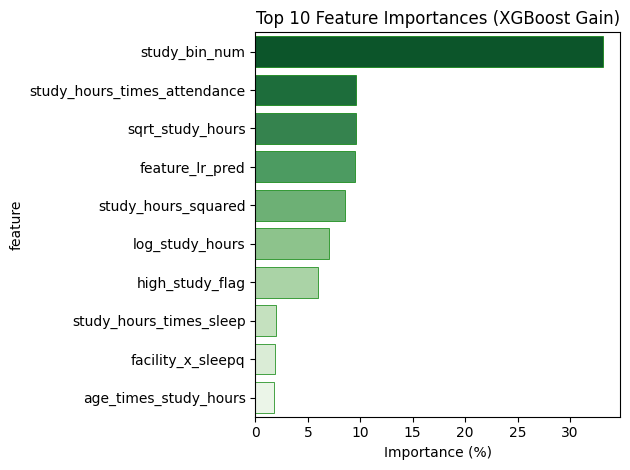

In [23]:
plt.figure()
sns.barplot(x="importance_pct", y="feature", data=feature_importance.head(10),palette="Greens_r",edgecolor='green',linewidth=.5 )
plt.title("Top 10 Feature Importances (XGBoost Gain)")
plt.xlabel("Importance (%)")
plt.tight_layout()
plt.show()